In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from mmf_speckle import *
from __init__ import *

In [3]:
import torch
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import numpy as np

In [4]:
device="cuda"
dtype=torch.float64
root="./results"

In [5]:
Width=128
Height=128
N = Width*Height
M = int(0.1526*N)

In [6]:
A_u = get_mmf_speckle_measure_matrix(25,device,dtype)

In [7]:
nosie_sigma_list = [0,0.5,1,1.5,2]

In [11]:
# Data Preparation
nosie_sigma = 0.5  # modify here
nosie= nosie_sigma > 0

# reconstruction of 7 unknown images
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
y_uu_list = [] 
x_uu_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype,W=Width,H=Height)
    y_u = speckle_measure(A_u, x_u.reshape((-1,1)), nosie=nosie, nosie_sigma=nosie_sigma) 
    y_uu_list.append(y_u)
    x_uu_list.append(x_u)

## Calibration

In [9]:
A = get_mmf_speckle_measure_matrix(0,device,dtype)
for i in range(4,7):
    A[i,:] = x_uu_list[i].reshape((1,-1))
Base, _ = torch.linalg.qr(A.T)
print(Base.shape)

torch.Size([16384, 2500])


In [10]:
Y = A @ Base
Y_u = speckle_measure(A_u, Base, nosie=nosie, nosie_sigma=nosie_sigma) 

In [11]:
L = torch.linalg.pinv(Y.T) @ torch.linalg.pinv(Y)
print(Y.T @ L @ Y)
print(Y[:,1].reshape((-1,1)).T @ L @ Y[:,0].reshape((-1,1)))

tensor([[ 1.0000e+00, -1.0705e-11, -1.8085e-11,  ...,  9.2273e-14,
         -4.9591e-13, -1.4679e-12],
        [-2.5210e-11,  1.0000e+00, -8.3668e-12,  ...,  7.6718e-14,
         -1.6551e-13, -5.5001e-13],
        [-2.2978e-12, -6.0664e-13,  1.0000e+00,  ...,  3.6173e-14,
         -6.7542e-14, -3.2547e-13],
        ...,
        [-1.9456e-13, -7.1154e-14, -3.4588e-14,  ...,  1.0000e+00,
          3.9655e-15, -1.3833e-15],
        [-4.6434e-13, -1.9437e-13, -1.0278e-13,  ...,  3.9771e-15,
          1.0000e+00,  1.7841e-15],
        [-3.9639e-13, -1.7137e-13, -9.2991e-14,  ..., -2.6264e-15,
          1.8008e-15,  1.0000e+00]], device='cuda:0', dtype=torch.float64)
tensor([[-6.0716e-12]], device='cuda:0', dtype=torch.float64)


In [12]:
A_recv = torch.zeros_like(A,device=device,dtype=dtype)
for i in tqdm(range(M)):
    A_recv += mismatch_equation(Y[:,i].reshape((-1,1)), Y_u[:,i].reshape((-1,1)), A, float64=True, _L=L)

100%|██████████| 2500/2500 [31:49<00:00,  1.31it/s]


In [13]:
print(A_recv)
f = h5py.File("{}/calibrationM/A_recvs.h5".format(root),"a")
f.create_dataset("nosie_{}".format(nosie_sigma), data=A_recv.cpu().numpy())  
f.create_dataset("y_nosie_{}".format(nosie_sigma), data=np.array([y.cpu().numpy() for y in y_uu_list]))    
f.close()

tensor([[ 0.6793,  0.4656,  0.8282,  ..., -0.2312,  0.1750,  0.2298],
        [ 0.6681,  0.5287,  0.9794,  ...,  0.7721,  0.4268,  0.2563],
        [ 0.8456,  0.6503,  0.3818,  ...,  1.0579,  1.1552,  0.9768],
        ...,
        [ 0.4438,  0.7055,  0.7719,  ...,  0.2914,  0.1140,  0.7371],
        [ 0.6869,  0.7440,  0.8678,  ...,  0.0116, -0.2669, -0.3814],
        [ 0.4168,  0.7789,  0.3548,  ...,  0.4417,  0.3384,  1.0803]],
       device='cuda:0', dtype=torch.float64)


In [14]:
b = torch.rand(M,1,device=device,dtype=dtype)
x = Base @ b
error = A_recv @ x - speckle_measure(A_u, x, nosie=nosie, nosie_sigma=nosie_sigma) 
print(abs(error).mean())

tensor(11.5054, device='cuda:0', dtype=torch.float64)


In [15]:
error = A_recv @ x_uu_list[4].reshape((-1,1)) - y_uu_list[4] 
print(abs(error).mean())

tensor(24.6570, device='cuda:0', dtype=torch.float64)


## Recv

In [8]:
from trad_cs_recv_algos import *

In [9]:
W = dct_matrix(N,dtype=dtype,device=device)
WT = torch.inverse(W)

In [10]:
tau=.35
stopCri = 4
tolA = 1.e15
tolD = 0.0001

In [12]:
f = h5py.File("{}/calibrationM/A_recvs.h5".format(root))
recv_res=[]
error_res=[]
for n in nosie_sigma_list:
    recv_n_res=[]
    error_n_res=[]
    total = len(names)
    y_list = torch.tensor(np.array(f["y_nosie_{}".format(n)]),dtype=dtype,device=device)
    A_recv = torch.tensor(np.array(f["nosie_{}".format(n)]),dtype=dtype,device=device)
    for j in range(total):
        y = y_list[j]
        error = y - A_recv @ x_uu_list[j].reshape((-1,1))
        e = abs(error).mean()
        print(e)

        AW = A_recv @ W
        hR = lambda x: AW @ x
        AT = lambda x: AW.T @ x

        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=tolD,
                Iters=100,
                Verbose=False
            )
        recv_img = (W @ theta)
        print("done")
        recv_n_res.append(recv_img)
        error_n_res.append(e.item())
    recv_res.append(recv_n_res)
    error_res.append(error_n_res)
f.close()

tensor(0.1421, device='cuda:0', dtype=torch.float64)
done
tensor(0.4727, device='cuda:0', dtype=torch.float64)
done
tensor(0.3255, device='cuda:0', dtype=torch.float64)
done
tensor(0.3873, device='cuda:0', dtype=torch.float64)
done
tensor(1.8421e-07, device='cuda:0', dtype=torch.float64)
done
tensor(1.9319e-07, device='cuda:0', dtype=torch.float64)
done
tensor(2.0144e-07, device='cuda:0', dtype=torch.float64)
done
tensor(9.5832, device='cuda:0', dtype=torch.float64)
done
tensor(27.2478, device='cuda:0', dtype=torch.float64)
done
tensor(23.9558, device='cuda:0', dtype=torch.float64)
done
tensor(24.9748, device='cuda:0', dtype=torch.float64)
done
tensor(24.6570, device='cuda:0', dtype=torch.float64)
done
tensor(27.1214, device='cuda:0', dtype=torch.float64)
done
tensor(27.1727, device='cuda:0', dtype=torch.float64)
done
tensor(19.2443, device='cuda:0', dtype=torch.float64)
done
tensor(53.9020, device='cuda:0', dtype=torch.float64)
done
tensor(47.4522, device='cuda:0', dtype=torch.float64

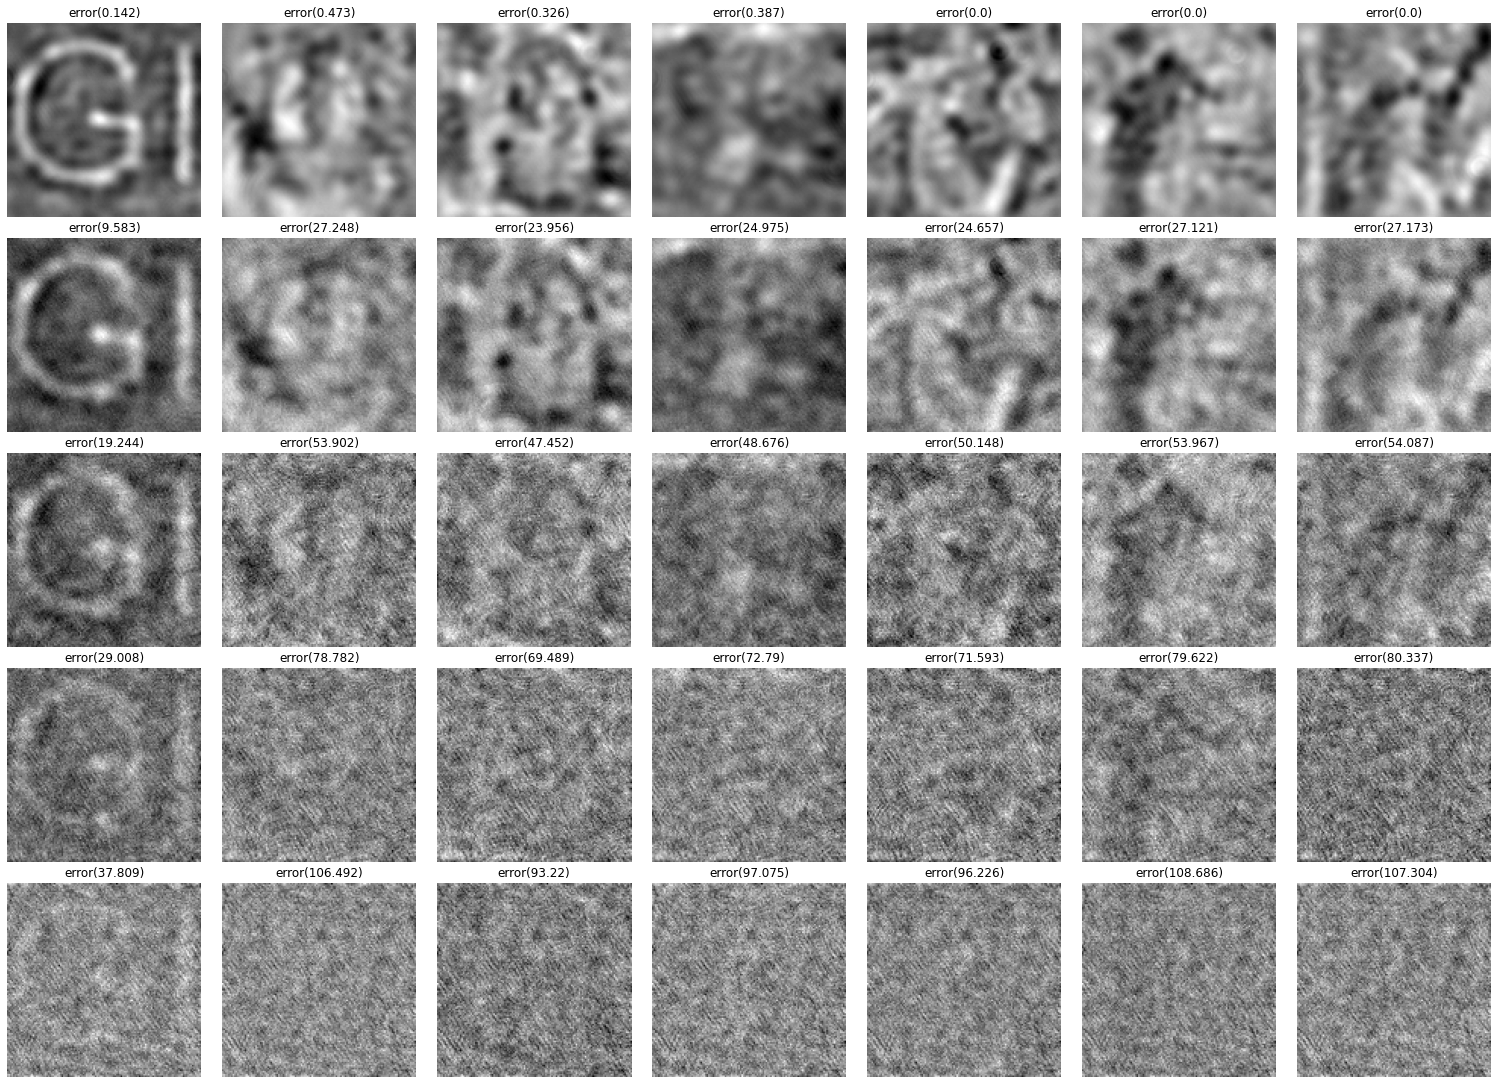

In [15]:
rows = len(nosie_sigma_list)
columns = len(names)
plt.figure(figsize=(columns*3,rows*3))
for i in range(rows):
    for j in range(columns):
        plt.subplot(rows,columns,j+1+columns*i)
        recv_img = recv_res[i][j]
        e = error_res[i][j]
        plt.imshow(recv_img.cpu().numpy().reshape((Width,Height)),cmap="gray")
        plt.title("error({})".format(round(e,3)))
        plt.axis("off")
plt.tight_layout(pad=0.5)
# plt.show()
plt.savefig("{}/calibrationM/recv_res.jpg".format(root))